In [2]:
from torchdiffeq import odeint_adjoint as odeint
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import pprint
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torchviz
import einops
torch.cuda.is_available()

True

In [4]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F 
from torch.autograd import Variable

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


use_cuda = torch.cuda.is_available()
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


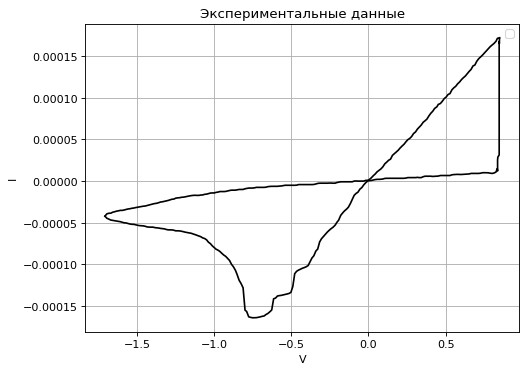

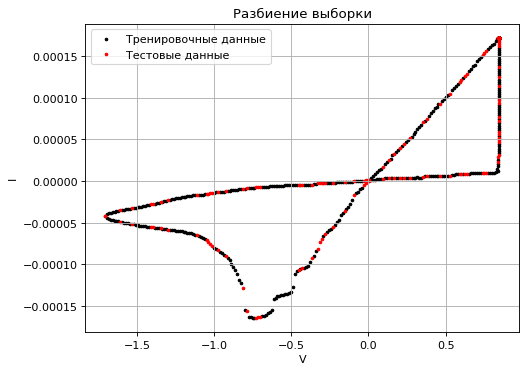

: 

In [14]:
from data_utils import load_existing_experimental_dataset, viz_existing_experimental_dataset
_ = load_existing_experimental_dataset()
_ = viz_existing_experimental_dataset()

In [6]:
from augmented_models import ODEFunc, ODEBlock, simpleRNN

In [15]:
trainloader, testloader, full_X, full_y, no_noise_y = build_dataset('experimental_saved', 64)

In [18]:
x, y = next(iter(trainloader))
x.shape

torch.Size([64, 2])

In [33]:
rnn_model = simpleRNN(device='cuda',
                       data_dim=2,
                       augment_dim=3,
                         hidden_dim=8,
                           non_linearity='tanh', timesteps_count=2).to('cuda')
print(rnn_model(x.to('cuda')).shape)

def use_rnn(model, x):
    return model(x)[:, :model.data_dim]

print(use_rnn(rnn_model, x.to('cuda')).shape)


odefunc = ODEFunc(device='cuda',
                       data_dim=2,
                       augment_dim=3,
                         hidden_dim=8,
                         non_linearity = 'tanh',
                            time_dependent = False ).to('cuda')
odeblock_model = ODEBlock(device = 'cuda',
                          odefunc=odefunc,
                            adjoint=True,
                              method='bosh3').to('cuda')

print(odeblock_model(x.to('cuda')).shape)

def use_ode(model, x):
    return model(x)[:, :model.odefunc.data_dim]

print(use_ode(odeblock_model, x.to('cuda')).shape)

torch.Size([64, 5])
torch.Size([64, 2])
torch.Size([64, 5])
torch.Size([64, 2])


In [7]:
sweep_config = {
    'method': 'random'
    }
    
metric = {
    'name': 'test_mse',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric    

In [8]:
parameters_dict = {
    # choose model
    'model_type': {'values': ['ode', 'rnn']},
    # dataset params
    'dataset_type': {'value': 'experimental_saved'}, 
    # fixed params
    'optimizer': {'value': 'adam'},
    # architecture params
    'arch_in_dim' : {'value': 2},
    'arch_hid_dim' : {'value': 8},
    'arch_aug_dim' : {'values': [0, 1, 2]},
    'arch_non_linearity' : {'value': 'tanh'},
    # learning params
    'epochs' : {'values': [2000]},
    'early_stop_epochs' : {'value' : 100},
    'batch_size' : {'value': 64},
    'learning_rate' : {'value': 0.01},
    # neural ODE specific params
    'solver_type' : {'value' : 'euler'},
    # 'solver_type' : {'values' : ['euler', 'rk4', 'dopri5', 'bosh3']},
    'time_idependent_num_ts' : {'value' : 2},
    # 'time_idependent_num_ts' : {'values' : [2, 10, 20]},
    'return_whole_sequence' : {'value' : False},

    # 'fc_layer_size': {
    #     'values': [128, 256, 512]
    #     },
    # 'dropout': {
    #       'values': [0.3, 0.4, 0.5]
    #     },
    }

sweep_config['parameters'] = parameters_dict

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'test_mse'},
 'parameters': {'arch_aug_dim': {'values': [0, 1, 2]},
                'arch_hid_dim': {'value': 8},
                'arch_in_dim': {'value': 2},
                'arch_non_linearity': {'value': 'tanh'},
                'batch_size': {'value': 64},
                'dataset_type': {'value': 'experimental_saved'},
                'early_stop_epochs': {'value': 100},
                'epochs': {'values': [2000]},
                'learning_rate': {'value': 0.01},
                'model_type': {'values': ['ode', 'rnn']},
                'optimizer': {'value': 'adam'},
                'return_whole_sequence': {'value': False},
                'solver_type': {'value': 'euler'},
                'time_idependent_num_ts': {'value': 2}}}


Adaptive-step:
- dopri8 Runge-Kutta 7(8) of Dormand-Prince-Shampine
- dopri5 Runge-Kutta 4(5) of Dormand-Prince [default].
- bosh3 Runge-Kutta 2(3) of Bogacki-Shampine
- adaptive_heun Runge-Kutta 1(2)

Fixed-step:
- euler Euler method.
- midpoint Midpoint method.
- rk4 Fourth-order Runge-Kutta with 3/8 rule.
- explicit_adams Explicit Adams.
- implicit_adams Implicit Adams.

In [9]:
# config.dataset_type
from data_utils import load_existing_hyst_dataset, create_hyst_dataset, load_existing_experimental_dataset, viz_existing_experimental_dataset
from data_utils import unscale_I
from tqdm.notebook import tqdm



criterion = torch.nn.functional.mse_loss

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        trainloader, testloader, full_X, full_y, no_noise_y = build_dataset(config.dataset_type, config.batch_size)
        
        network = build_network(config)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)
        train_epochs(model=network,
                      train_loader=trainloader,
                       test_loader=testloader,
                         criterion=criterion,
                           optimizer=optimizer,  
                           full_X=full_X,
                             full_y=full_y,
                            viz_data=no_noise_y, 
                             config=config)
 
def build_dataset(which, batch_size):
    """
    which: 'hyst', 'hyst_saved', 'experimental', 'experimental_saved'
    """
    if which=='hyst':
        train_dataset, test_dataset, X_full, y_full, no_noise_y  = create_hyst_dataset()
    elif which=='hyst_saved':
        train_dataset, test_dataset, X_full, y_full, no_noise_y = load_existing_hyst_dataset()
    elif which == 'experimental_saved':
        train_dataset, test_dataset, X_full, y_full, no_noise_y = load_existing_experimental_dataset()    

    trainloader = torch.utils.data.DataLoader(
                  train_dataset, 
                  batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(
                    test_dataset,
                    batch_size=batch_size)

    return trainloader, testloader, X_full, y_full, no_noise_y


def build_network(config):
    if config.model_type == 'rnn':
        model = simpleRNN(device=device,
                            data_dim=2,
                            augment_dim=config.arch_aug_dim,
                                hidden_dim=config.arch_hid_dim,
                                non_linearity=config.arch_non_linearity,
                                  timesteps_count=config.time_idependent_num_ts).to(device)

        # def use_rnn(model, x):
        #     return model(x)[:, :model.data_dim]
    elif config.model_type == 'ode':
        odefunc = ODEFunc(device=device,
                            data_dim=2,
                            augment_dim=config.arch_aug_dim,
                                hidden_dim=config.arch_hid_dim,
                                non_linearity=config.arch_non_linearity,
                                    time_dependent = False ).to(device)
        model = ODEBlock(device = device,
                            odefunc=odefunc,
                            adjoint=True,
                                method=config.solver_type).to(device)


        # def use_ode(model, x):
        #     return model(x)[:, :model.odefunc.data_dim]
    return model
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epochs(model, train_loader, test_loader, criterion, optimizer, full_X, full_y, viz_data, config):
        # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    """
    includes:
    learning for n epochs
    logging train loss every epoch
    testing on val_set every epoch
    logging test loss every epoch

    saving weights for best epoch
    logging visualisation to wandb for best epoch

    """

    wandb.watch(model, criterion, log="all", log_freq=10)

    # time to input to odeint
    t = torch.linspace(0, 1, config.time_idependent_num_ts).to(device)
    # Run training and track with wandb
    total_batches = len(train_loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    min_val_loss = 1000
    val_loss = min_val_loss
    no_better_counter = 0 
    for epoch in tqdm(range(config.epochs)):
        for _, (x, y) in enumerate(train_loader):

            # loss = train_batch_ode(x, y, t, model, optimizer, criterion, config)
            loss = train_batch(x, y, t, model, optimizer, criterion, config)
            example_ct +=  len(x)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                print(f'logging: {epoch=}, {example_ct=}, {loss=}, {val_loss=}, {min_val_loss=}')
                wandb.log({"epoch": epoch, "train_mse": loss}, step=example_ct)
        no_better_counter += 1         
        
        if (epoch + 1) % 25 == 0:
            with torch.no_grad():
                val_loss = test_log_vis(model,
                                         t,
                                           test_loader,
                                            train_loader,
                                             epoch,
                                               example_ct,
                                                min_val_loss,
                                                full_X, full_y, viz_data,
                                                  config)
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    no_better_counter = 0 

        if no_better_counter > config.early_stop_epochs:
            print(f'Early stopping: {no_better_counter=}')
            break

def train_batch(x, y, t, model, optimizer, criterion, config):
    optimizer.zero_grad()
    x, y = x.to(device), y.to(device)
    
    # Forward pass ➡
    if config.model_type == 'rnn':
        pred_y = model(x)[:, :model.data_dim]
    elif config.model_type == 'ode': 
        pred_y = model(x)[:, :model.odefunc.data_dim]       
    
    loss = criterion(pred_y, y)
    
    # Backward pass ⬅
    loss.backward()

    # Step with optimizer
    optimizer.step()
    return loss

# def train_batch_ode(x, y, t, model, optimizer, criterion, config): 
#     optimizer.zero_grad()
#     x, y = x.to(device), y.to(device)
        
#     # Forward pass ➡
#     pred_y = odeint(model, y0=x, t=t, method=config.solver_type, adjoint_method=config.solver_type).to(device)
#     if not config.return_whole_sequence:
#         pred_y=pred_y[-1]
        
#     loss = criterion(pred_y, y)
    
#     # Backward pass ⬅
#     loss.backward()

#     # Step with optimizer
#     optimizer.step()
#     return loss

def test_log_vis(model, t, test_loader, train_loader, epoch, example_ct, min_val_loss, full_X, full_y, viz_data, config):
    with torch.no_grad():
        val_loss = 0 

        # X_test = []
        # y_test = []
        t.to(device)
        for _, (x, y) in enumerate(test_loader): 
            x, y = x.to(device), y.to(device)

            if config.model_type == 'rnn':
                pred_y = model(x)[:, :model.data_dim]
            elif config.model_type == 'ode': 
                pred_y = model(x)[:, :model.odefunc.data_dim] 

            loss = criterion(pred_y, y)
            val_loss+=loss

            # X_test.append(x)
            # y_test.append(y)

        val_loss /= len(test_loader)
        val_loss = val_loss.cpu().item()   
        print(f'testing: {val_loss=}') 

        wandb.log({"epoch": epoch, "test_mse": val_loss}, step=example_ct) 
        # visualising:
        if val_loss < min_val_loss: 
            """ X_train y_train X_test y_test X_full, y_full"""
            # X_train = []
            # y_train = []
           
            # X_train = torch.cat(X_train, dim=0)
            # X_test = torch.cat(X_test, dim=0)
            # y_train = torch.cat(y_train, dim=0)
            # y_test = torch.cat(y_test, dim=0)
            X_train, X_test, y_train, y_test, glob_min, glob_max = viz_data
            full_X = torch.Tensor(full_X).to(device)


            if config.model_type == 'rnn':
                z_full = model(full_X)[:, :model.data_dim]
            elif config.model_type == 'ode': 
                z_full = model(full_X)[:, :model.odefunc.data_dim]
            z_full = z_full.cpu()    
            full_X = full_X.cpu()     

            # z_full = odeint(model, t=t.to(device), y0=full_X.to(device), method=config.solver_type, adjoint_method=config.solver_type).to(device)
            # if not config.return_whole_sequence:
            #     z_full=z_full[-1].cpu()
            # full_X=full_X.cpu()
            # X_train=X_train.cpu()
            # X_test=X_test.cpu()
            # y_train = y_train.cpu()
            # y_test = y_test.cpu()
            plt.close()

            # scale
            z_full = unscale_I(z_full, glob_min, glob_max)
            y_train = unscale_I(y_train, glob_min, glob_max)
            y_test = unscale_I(y_test, glob_min, glob_max)

            plt.figure(figsize=(10, 7), dpi=100)
            sc_1 = plt.scatter(X_train[:, 0], y_train[:, 0], color = 'black', s=5, label = 'Тренировочные данные')
            plt.scatter(X_train[:, 0], y_train[:, 1], color = 'black', s=5)
            sc_2 = plt.scatter(X_test[:, 0], y_test[:, 0], color = 'red', s=5, label = 'Тестовые данные')
            plt.scatter(X_test[:, 0], y_test[:, 1], color = 'red', s=5)
            plt.plot(full_X[:, 0], z_full[:, 0], color = 'green', label = 'Аппроксимация')
            plt.plot(full_X[:, 0], z_full[:, 1], color = 'green')
            
            # t = np.linspace(-3*np.pi/4, np.pi/4, 100, endpoint = True)
            # plt.plot(t, np.sin(t), color = 'pink', label = 'Незашумленные данные')
            # plt.plot(t, np.cos(t), color = 'pink')
            plt.legend()
            plt.xlabel('V')
            plt.ylabel('I')
            plt.title('Результат ') 
            plt.grid()
        
            wandb.log({"Result": wandb.Image(plt), 'epoch': epoch}, step=example_ct)
        return val_loss               

In [42]:
device

'cuda'

In [10]:
parameters_dict

{'model_type': {'values': ['ode', 'rnn']},
 'dataset_type': {'value': 'experimental_saved'},
 'optimizer': {'value': 'adam'},
 'arch_in_dim': {'value': 2},
 'arch_hid_dim': {'value': 8},
 'arch_aug_dim': {'values': [0, 1, 2]},
 'arch_non_linearity': {'value': 'tanh'},
 'epochs': {'values': [2000]},
 'early_stop_epochs': {'value': 100},
 'batch_size': {'value': 64},
 'learning_rate': {'value': 0.01},
 'solver_type': {'value': 'euler'},
 'time_idependent_num_ts': {'value': 2},
 'return_whole_sequence': {'value': False}}

In [11]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-experimental")

Create sweep with ID: xruroslq
Sweep URL: https://wandb.ai/peter_chizhov/pytorch-sweeps-experimental/sweeps/xruroslq


wandb: Agent Starting Run: o8saijmm with config:
wandb: 	arch_aug_dim: 1
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: rnn
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.019481545314192772
logging: epoch=30, example_ct=6231, loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.019481545314192772, min_val_loss=0.019481545314192772
logging: epoch=37, example_ct=7501, loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.019481545314192772, min_val_loss=0.019481545314192772
logging: epoch=43, example_ct=8771, loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLos

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse,█▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
test_mse,0.00199
train_mse,0.00182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f8lgtgkq with config:
wandb: 	arch_aug_dim: 2
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: rnn
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.0839, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.00909519288688898
logging: epoch=30, example_ct=6231, loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.00909519288688898, min_val_loss=0.00909519288688898
logging: epoch=37, example_ct=7501, loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.00909519288688898, min_val_loss=0.00909519288688898
logging: epoch=43, example_ct=8771, loss=tensor(0.0056, device='cuda:0', grad_fn=<MseLossBack

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse,█▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
test_mse,0.00179
train_mse,0.00168


wandb: Agent Starting Run: de9km30h with config:
wandb: 	arch_aug_dim: 2
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: rnn
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.0164813045412302
logging: epoch=30, example_ct=6231, loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.0164813045412302, min_val_loss=0.0164813045412302
logging: epoch=37, example_ct=7501, loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.0164813045412302, min_val_loss=0.0164813045412302
logging: epoch=43, example_ct=8771, loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse,█▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▆▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁
epoch,1349
test_mse,0.00182
train_mse,0.00172


wandb: Agent Starting Run: jlewuvwb with config:
wandb: 	arch_aug_dim: 2
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: ode
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.1489, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0497, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.017414629459381104
logging: epoch=30, example_ct=6231, loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.017414629459381104, min_val_loss=0.017414629459381104
logging: epoch=37, example_ct=7501, loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.017414629459381104, min_val_loss=0.017414629459381104
logging: epoch=43, example_ct=8771, loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLos

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse,█▇▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1449
test_mse,0.00188
train_mse,0.00172


wandb: Agent Starting Run: bspttu50 with config:
wandb: 	arch_aug_dim: 2
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: ode
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.0642, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.017708202823996544
logging: epoch=30, example_ct=6231, loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.017708202823996544, min_val_loss=0.017708202823996544
logging: epoch=37, example_ct=7501, loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.017708202823996544, min_val_loss=0.017708202823996544
logging: epoch=43, example_ct=8771, loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLos

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
test_mse,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1724
test_mse,0.00174
train_mse,0.00187


wandb: Agent Starting Run: eeh6x7nw with config:
wandb: 	arch_aug_dim: 0
wandb: 	arch_hid_dim: 8
wandb: 	arch_in_dim: 2
wandb: 	arch_non_linearity: tanh
wandb: 	batch_size: 64
wandb: 	dataset_type: experimental_saved
wandb: 	early_stop_epochs: 100
wandb: 	epochs: 2000
wandb: 	learning_rate: 0.01
wandb: 	model_type: rnn
wandb: 	optimizer: adam
wandb: 	return_whole_sequence: False
wandb: 	solver_type: euler
wandb: 	time_idependent_num_ts: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


  0%|          | 0/2000 [00:00<?, ?it/s]

logging: epoch=5, example_ct=1206, loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=12, example_ct=2476, loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=18, example_ct=3746, loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
logging: epoch=24, example_ct=5016, loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=1000, min_val_loss=1000
testing: val_loss=0.01623694784939289
logging: epoch=30, example_ct=6231, loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.01623694784939289, min_val_loss=0.01623694784939289
logging: epoch=37, example_ct=7501, loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>), val_loss=0.01623694784939289, min_val_loss=0.01623694784939289
logging: epoch=43, example_ct=8771, loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBack

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_mse,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
test_mse,0.00244
train_mse,0.00226


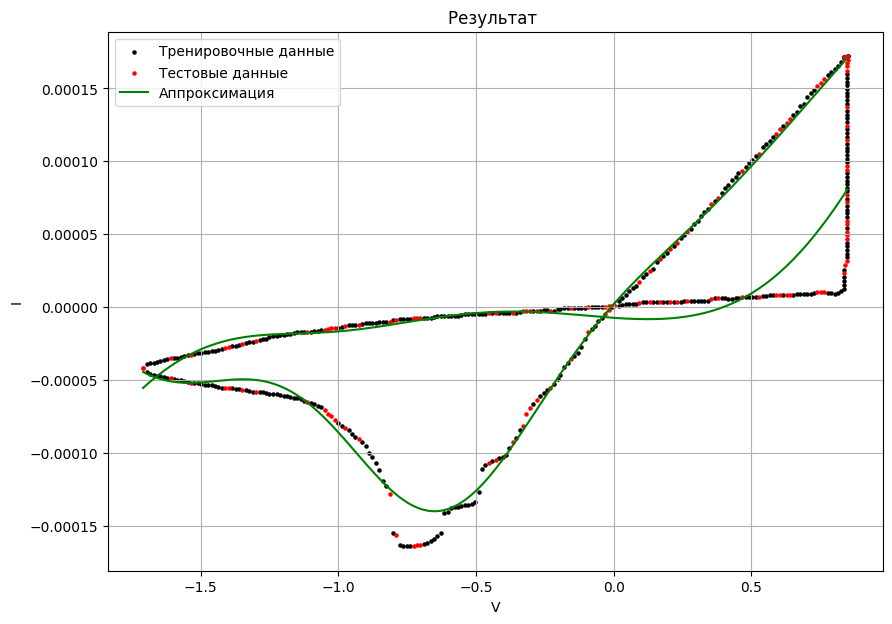

In [12]:
wandb.agent(sweep_id, train, count=6)